tutorial
https://pystan.readthedocs.io/en/latest/getting_started.html

In [1]:
import pystan

In [2]:
schools_code = """
data {
    int<lower=0> J; // number of schools
    vector[J] y; // estimated treatment effects
    vector<lower=0>[J] sigma; // s.e. of effect estimates
}
parameters {
    real mu;
    real<lower=0> tau;
    vector[J] eta;
}
transformed parameters {
    vector[J] theta;
    theta = mu + tau * eta;
}
model {
    eta ~ normal(0, 1);
    y ~ normal(theta, sigma);
}
"""

schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}

sm = pystan.StanModel(model_code=schools_code)
fit = sm.sampling(data=schools_dat, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_19a09b474d1901f191444eaf8a6b8ce2 NOW.


In [3]:
la = fit.extract(permuted=True)  # return a dictionary of arrays
mu = la['mu']

## return an array of three dimensions: iterations, chains, parameters
a = fit.extract(permuted=False)

/home/watanabe/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead


In [4]:
print(fit)


Inference for Stan model: anon_model_19a09b474d1901f191444eaf8a6b8ce2.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu         8.45    0.23   5.66  -1.61   4.66   8.06  11.75  21.48    590   1.01
tau        6.74    0.24    5.8   0.23   2.54   5.26   9.14  21.17    597   1.01
eta[0]     0.38    0.02   0.93  -1.46  -0.23   0.39   0.98   2.21   2000    1.0
eta[1]    -0.03    0.02   0.89  -1.77  -0.64-9.2e-3   0.56   1.73   2000    1.0
eta[2]     -0.2    0.02   0.95  -2.03  -0.85  -0.19   0.44   1.63   2000    1.0
eta[3]    -0.07    0.02    0.9  -1.85  -0.67  -0.08   0.51   1.69   2000    1.0
eta[4]     -0.4    0.02   0.87   -2.0  -0.98  -0.44   0.15   1.42   2000    1.0
eta[5]    -0.24    0.02   0.89  -1.99  -0.82  -0.25   0.35    1.6   2000    1.0
eta[6]     0.28    0.02   0.87  -1.46  -0.29   0.28   0.86   1.98   1421    1.0
eta[7]     0.

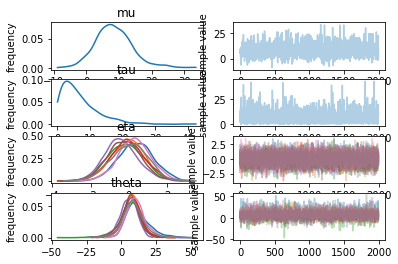

In [5]:
fit.plot()


https://qiita.com/kenmatsu4/items/dd9593edf282d44168d3

In [29]:
import numpy as np
import numpy.random as rd
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation as ani
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)

from tabulate import tabulate
from time import time

import pystan
from pystan import StanModel

from sklearn import cross_validation
from scipy.stats import gaussian_kde

In [30]:
titanic = pd.read_table("https://raw.githubusercontent.com/matsuken92/Qiita_Contents/master/PyStan-Titanic/data/titanic_converted.csv",
              sep=",", header=0)
titanic.head(10)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
0,0,3,1,22.0,1,0,7.2500,1,3,1,1,0,3,1
1,1,1,0,38.0,1,0,71.2833,2,1,2,0,3,1,0
2,1,3,0,26.0,0,0,7.9250,1,3,2,0,0,3,0
3,1,1,0,35.0,1,0,53.1000,1,1,2,0,3,3,0
4,0,3,1,35.0,0,0,8.0500,1,3,1,1,0,3,1
5,0,3,1,28.0,0,0,8.4583,3,3,1,1,0,2,1
6,0,1,1,54.0,0,0,51.8625,1,1,1,1,5,3,1
7,0,3,1,2.0,3,1,21.0750,1,3,0,0,0,3,0
8,1,3,0,27.0,0,2,11.1333,1,3,2,0,0,3,0
9,1,2,0,14.0,1,0,30.0708,2,2,0,0,0,1,0


In [31]:
target = titanic.ix[:, 0]
data = titanic.ix[:, [1,2,3,4,5,6]]

# 訓練データ(80%), テストデータ(20%)に分割する
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.2, random_state=0)
print ([d.shape for d in [X_train, X_test, y_train, y_test]])

[(712, 6), (179, 6), (712,), (179,)]


In [32]:
dat = {'N': X_train.shape[0], 'M': X_train.shape[1], 'X': X_train, 'y': y_train}


In [33]:
code = """
        data {
            int<lower=0> N;
            int<lower=0> M;
            matrix[N, M] X;
            int<lower=0, upper=1> y[N];
        } parameters {
            real beta0;
            vector[M] beta; 
        } model {
            for (i in 1:N)
                y[i] ~ bernoulli(inv_logit (beta0 + dot_product(X[i] , beta)));
        }
        """

In [34]:
%time stm = StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b12e3f2368679a0c562b9f74618b2f82 NOW.


CPU times: user 1.09 s, sys: 43.8 ms, total: 1.13 s
Wall time: 45 s


In [35]:
n_itr = 6000
n_warmup = 1500
chains = 2

# サンプリングの実行 （algorithm="NUTS"にすると収束しない）
%time fit = stm.sampling(data=dat, iter=n_itr, chains=chains, n_jobs=-1, warmup=n_warmup, algorithm="NUTS", verbose=False)
#%time fit = stm.sampling(data=dat, iter=n_itr, chains=chains, n_jobs=-1, warmup=n_warmup, verbose=False)
# サンプル列を抽出
la    = fit.extract(permuted=True)  # return a dictionary of arrays
# パラメーター名
names = fit.model_pars 
# パラメーターの数
n_param = np.sum([1 if len(x) == 0 else x[0] for x in fit.par_dims])

CPU times: user 222 ms, sys: 123 ms, total: 345 ms
Wall time: 4min 18s


In [36]:
n_param

7

In [37]:
print(fit)

Inference for Stan model: anon_model_b12e3f2368679a0c562b9f74618b2f82.
2 chains, each with iter=6000; warmup=1500; thin=1; 
post-warmup draws per chain=4500, total post-warmup draws=9000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0     5.04    0.01   0.59   3.89   4.65   5.04   5.44   6.16   2950    1.0
beta[0]  -1.05  2.9e-3   0.15  -1.35  -1.15  -1.05  -0.94  -0.74   2829    1.0
beta[1]  -2.77  2.7e-3   0.22  -3.21  -2.92  -2.77  -2.62  -2.34   6822    1.0
beta[2]  -0.04  1.2e-4 8.7e-3  -0.06  -0.05  -0.04  -0.04  -0.03   5543    1.0
beta[3]  -0.42  1.7e-3   0.13  -0.68   -0.5  -0.41  -0.33  -0.18   5558    1.0
beta[4]  -0.08  1.9e-3   0.13  -0.35  -0.17  -0.07   0.02   0.18   5027    1.0
beta[5] 2.5e-3  3.4e-5 2.6e-3-2.4e-3 7.7e-4 2.4e-3 4.1e-3 7.8e-3   5625    1.0
lp__    -322.4    0.03   1.92 -327.1 -323.4 -322.0 -321.0 -319.7   3325    1.0

Samples were drawn using NUTS at Fri Oct 19 11:14:10 2018.
For each parameter, n_eff is a crude mea

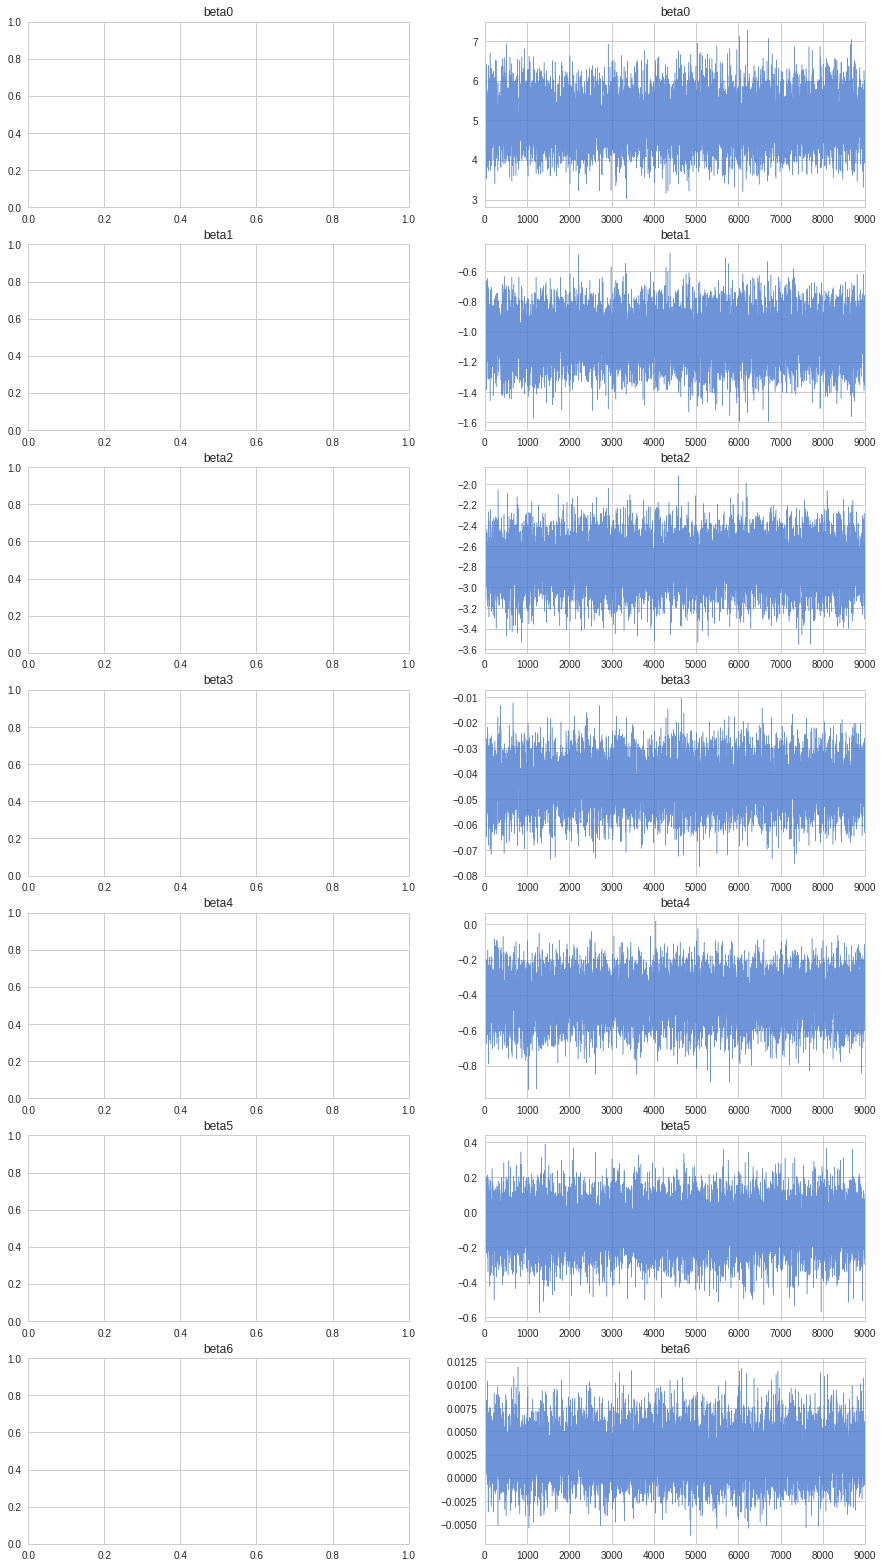

In [25]:
f, axes = plt.subplots(n_param, 2, figsize=(15, 4*n_param))
cnt = 0
for name in names:
    dat = la[name]
    if dat.ndim == 2:
        for j in range(dat.shape[1]):
            d = dat[:,j]
            #sns.distplot(d, hist=False, ax=axes[cnt, 0])
            sns.tsplot(d,   alpha=0.8, lw=.5, ax=axes[cnt, 1])
            cnt += 1
    else:
        # Intercept
        #sns.distplot(dat, hist=False, rug=True, ax=axes[cnt, 0])
        sns.tsplot(dat,   alpha=0.8, lw=.5, ax=axes[cnt, 1])
        cnt += 1

name_list = []
for name in names:
    if la[name].ndim == 2:
        for i in range(dat.shape[1]):
            name_list.append("{}{}".format(name,i+1))
    else:
        name_list.append(name)

for i in range(2):
    for j, t in enumerate(name_list):
        axes[j, i].set_title(t)
plt.show()

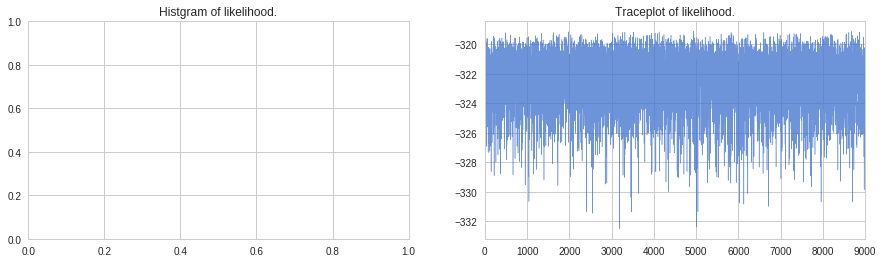

In [26]:
# Likelihood
f, axes = plt.subplots(1, 2, figsize=(15, 4))

#sns.distplot(la['lp__'], hist=False, rug=True, ax=axes[0])
sns.tsplot(la['lp__'],   alpha=0.8, lw=.5, ax=axes[1])
axes[0].set_title("Histgram of likelihood.")
axes[1].set_title("Traceplot of likelihood.")
plt.show()